# **Task 1: Medical Image Classification with PathMNIST Dataset**

In [ ]:
# Install necessary libraries
!pip install torch torchvision medmnist matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=44289c6e4e211f701c06020fdfff8d8a361c5c07abe25445b9f4c41539fecb9a
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


**Step 1: Data Loading**

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PathMNIST

# Ensure the root directory exists
root_dir = './data'
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
# Set download=True if not already downloaded
train_set = PathMNIST(root=root_dir, split='train', transform=transform, download=True)
val_set = PathMNIST(root=root_dir, split='val', transform=transform, download=True)
test_set = PathMNIST(root=root_dir, split='test', transform=transform, download=True)

# DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print("Dataset loaded successfully!")


100%|██████████| 206M/206M [04:35<00:00, 747kB/s]


Using downloaded and verified file: ./data/pathmnist.npz
Using downloaded and verified file: ./data/pathmnist.npz
Dataset loaded successfully!


**Step 2: Visualize Sample Data**

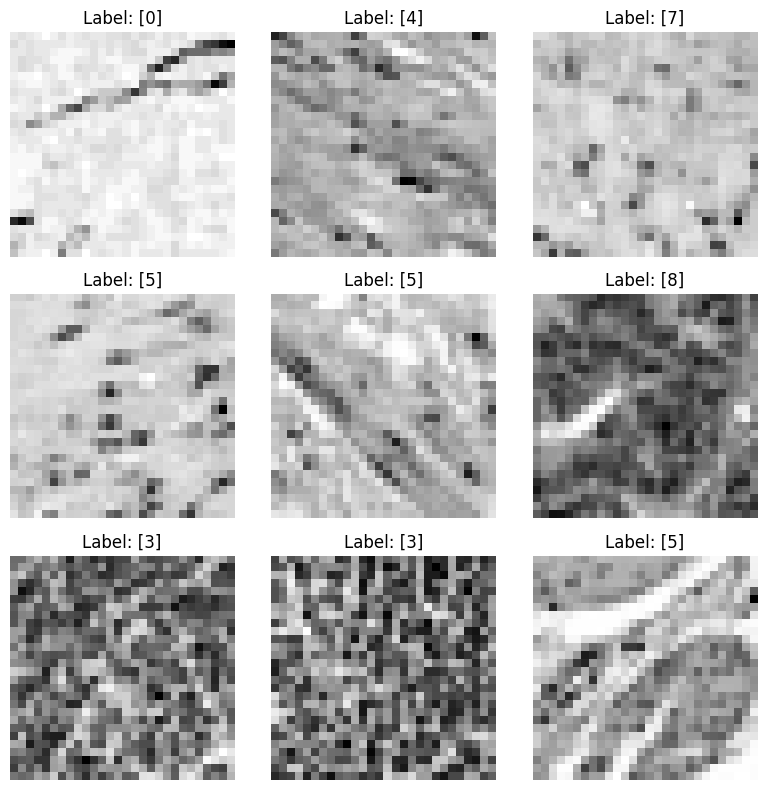

In [ ]:
import matplotlib.pyplot as plt

# Display 3x3 grid of images with labels
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    img, label = train_set[i]
    img = img[0]  # Take only the first channel to make it (28, 28)
    axs[i // 3, i % 3].imshow(img, cmap='gray')
    axs[i // 3, i % 3].set_title(f"Label: {label}")
    axs[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


**Step 3: Define the CNN Model**

In [ ]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Change input channels to 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


**Step 4: Train the Model**

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        # Reshape labels to 1D
        labels = labels.squeeze(1)  # Remove the extra dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation accuracy after each epoch
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # Reshape labels to 1D for validation as well
            labels = labels.squeeze(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print epoch loss and accuracy
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

    # Save model at the end of each epoch (optional)
    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")

# Save final model after all epochs
torch.save(model.state_dict(), "bscs22115_final_model.pth")


Epoch [1/10], Loss: 0.0633, Accuracy: 90.11%
Epoch [2/10], Loss: 0.0560, Accuracy: 92.48%
Epoch [3/10], Loss: 0.0490, Accuracy: 90.57%
Epoch [4/10], Loss: 0.0464, Accuracy: 91.52%
Epoch [5/10], Loss: 0.0465, Accuracy: 92.42%
Epoch [6/10], Loss: 0.0370, Accuracy: 91.00%
Epoch [7/10], Loss: 0.0388, Accuracy: 92.44%
Epoch [8/10], Loss: 0.0350, Accuracy: 91.42%
Epoch [9/10], Loss: 0.0364, Accuracy: 92.33%
Epoch [10/10], Loss: 0.0309, Accuracy: 92.24%


**Step 5: Evaluate the Model**

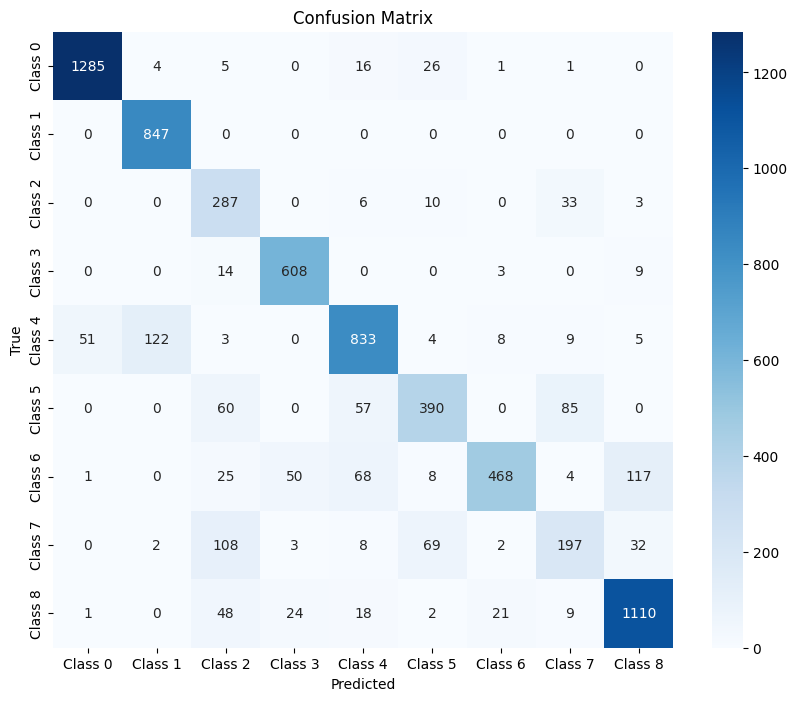

              precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96      1338
     Class 1       0.87      1.00      0.93       847
     Class 2       0.52      0.85      0.65       339
     Class 3       0.89      0.96      0.92       634
     Class 4       0.83      0.80      0.82      1035
     Class 5       0.77      0.66      0.71       592
     Class 6       0.93      0.63      0.75       741
     Class 7       0.58      0.47      0.52       421
     Class 8       0.87      0.90      0.88      1233

    accuracy                           0.84      7180
   macro avg       0.80      0.80      0.79      7180
weighted avg       0.85      0.84      0.84      7180



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names for PathMNIST (modify as needed if you have specific class names)
class_names = [f"Class {i}" for i in range(9)]  # Replace with actual class names if available

# Test model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.squeeze().tolist())  # Squeeze if labels have an extra dimension
        y_pred.extend(predicted.tolist())

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


# **Task 2: Image Segmentation with UNet using Pascal VOC 2012**

In [ ]:
# Install necessary libraries
!pip install torch torchvision matplotlib


In [ ]:
from torchvision.datasets import VOCSegmentation

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load dataset
train_data = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=transform)
val_data = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)


100%|██████████| 2.00G/2.00G [01:21<00:00, 24.5MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


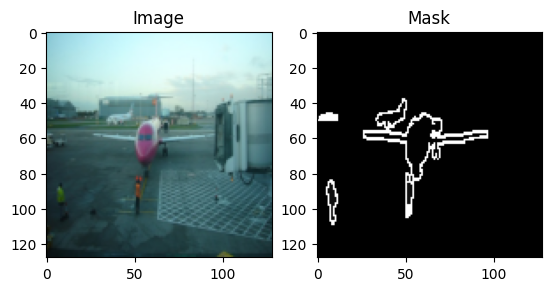

In [ ]:
# Display a sample image and its mask
image, mask = train_data[0]
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image.permute(1, 2, 0))
ax1.set_title("Image")
ax2.imshow(mask.squeeze(), cmap="gray")
ax2.set_title("Mask")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.enc_conv1 = self.double_conv(1, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder
        self.upconv4 = self.upconv(1024, 512)
        self.dec_conv4 = self.double_conv(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec_conv3 = self.double_conv(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec_conv2 = self.double_conv(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec_conv1 = self.double_conv(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(F.max_pool2d(enc1, 2))
        enc3 = self.enc_conv3(F.max_pool2d(enc2, 2))
        enc4 = self.enc_conv4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder path
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec_conv4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec_conv3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec_conv2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec_conv1(dec1)

        # Final layer
        out = self.final_conv(dec1)
        return out


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset  # or use another dataset

# Assuming you have a dataset of images and masks
# For demonstration, create random tensors for images and masks (replace with real data)
images = torch.randn(100, 3, 128, 128)  # 100 random images (e.g., RGB, 128x128)
masks = torch.randint(0, num_classes, (100, 128, 128))  # 100 random masks with values 0 or 1

# Create a dataset and DataLoader
dataset = TensorDataset(images, masks)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Set batch_size as needed

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        # Move images and masks to the appropriate device
        images = images.to(torch.device('cpu'))  # Change to your desired device
        masks = masks.to(torch.device('cpu'))  # Change to your desired device

        optimizer.zero_grad()
        outputs = model(images)  # Outputs should have shape (N, num_classes, H, W)

        # Ensure masks are of shape (N, H, W) for CrossEntropyLoss
        loss = criterion(outputs, masks)  # masks should be class indices (not one-hot encoded)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader):.4f}")

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')
print("Model saved to 'unet_model.pth'")


Epoch [1/10], Loss: 0.6951
Epoch [2/10], Loss: 0.6933
Epoch [3/10], Loss: 0.6932
Epoch [4/10], Loss: 0.6932
Epoch [5/10], Loss: 0.6932
Epoch [6/10], Loss: 0.6932
Epoch [7/10], Loss: 0.6932
Epoch [8/10], Loss: 0.6932
Epoch [9/10], Loss: 0.6932
Epoch [10/10], Loss: 0.6932
Model saved to 'unet_model.pth'


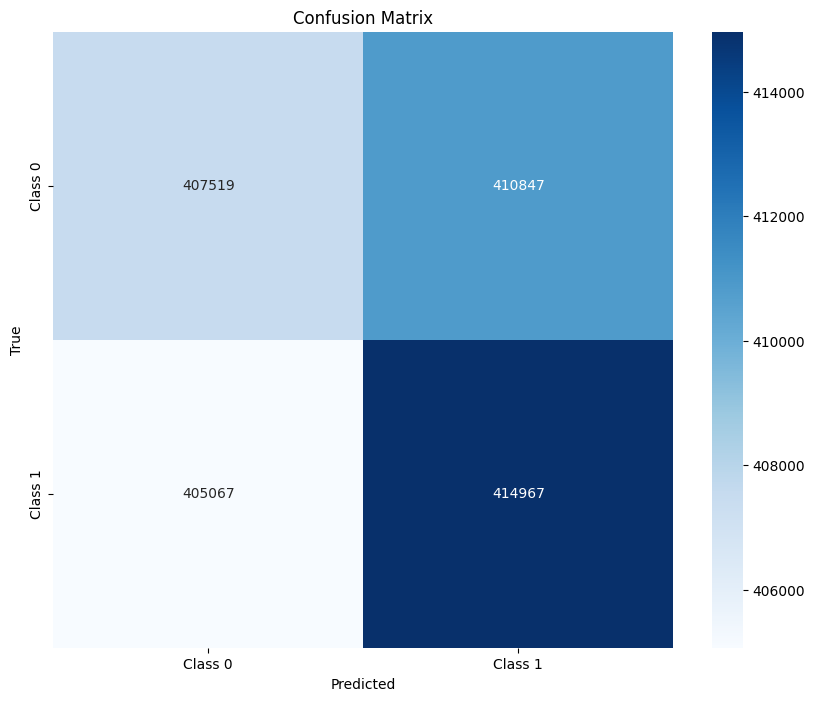

              precision    recall  f1-score   support

     Class 0       0.50      0.50      0.50    818366
     Class 1       0.50      0.51      0.50    820034

    accuracy                           0.50   1638400
   macro avg       0.50      0.50      0.50   1638400
weighted avg       0.50      0.50      0.50   1638400



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Define class names (adjust based on your dataset, e.g., 'Background' and 'Foreground' for binary segmentation)
class_names = [f"Class {i}" for i in range(num_classes)]  # Replace with actual class names if available

# Test model
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for images, masks in val_loader:  # Use your validation or test DataLoader
        images = images.to(torch.device('cpu'))  # Replace with your device ('cpu' or 'cuda')
        masks = masks.to(torch.device('cpu'))    # Ground truth masks

        outputs = model(images)  # Model outputs (N, num_classes, H, W)

        # Get the predicted class by selecting the class with max probability
        predicted = torch.argmax(outputs, dim=1)  # Predicted mask (N, H, W)

        # Flatten the output and ground truth to 1D arrays for comparison
        y_true.extend(masks.flatten().tolist())
        y_pred.extend(predicted.flatten().tolist())

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))
